In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('modified_tra.csv')
df.head(1)

,UserID,Taken_product,Yearly_avg_view_on_travel_page,total_likes_on_outstation_checkin_given,yearly_avg_Outstation_checkins,member_in_family,preferred_location_type,Yearly_avg_comment_on_travel_page,total_likes_on_outofstation_checkin_received,week_since_last_outstation_checkin,following_company_page,montly_avg_comment_on_company_page,working_flag,travelling_network_rating,Adult_flag,Daily_Avg_mins_spend_on_traveling_page
0,1000001,Yes,307.0,38570.0,1,2,Financial,94.0,5993,8,Yes,11,No,1,0.0,8.0


In [3]:
df.drop(columns = 'UserID', inplace = True)
df.iloc[2]

Taken_product                                       Yes
Yearly_avg_view_on_travel_page                    277.0
total_likes_on_outstation_checkin_given         48055.0
yearly_avg_Outstation_checkins                        1
member_in_family                                      2
preferred_location_type                           Other
Yearly_avg_comment_on_travel_page                  92.0
total_likes_on_outofstation_checkin_received       2090
week_since_last_outstation_checkin                    6
following_company_page                              Yes
montly_avg_comment_on_company_page                   15
working_flag                                         No
travelling_network_rating                             2
Adult_flag                                          0.0
Daily_Avg_mins_spend_on_traveling_page              7.0
Name: 2, dtype: object

In [4]:
# for col in df.columns:
#     print(col)
#     print(df[col].unique())

In [5]:
# following_company_page
df['following_company_page'].replace({'Yes': True
                                      , '1': True
                                      , '0': False
                                      , 'No': False}, inplace = True)

# member_in_family
df['member_in_family'].replace({'Three': 3}, inplace = True)

# Boolean columns
bool_cols = ['working_flag', 'Taken_product']
for col in bool_cols:
    df[col].replace({'Yes': True, 'No': False}, inplace = True)

# Drop *
df = df[df['yearly_avg_Outstation_checkins'] != '*']

# Location type
df['preferred_location_type'].replace({'Game': 'Other'
                                      , 'Tour  Travel': 'Other'
                                      , 'Tour and Travel': 'Other'
                                      , 'Movie': 'Other'
                                      , 'OTT': 'Other'
                                      }, inplace = True)

In [6]:
# Apply one-hot encoding
df = pd.get_dummies(df, columns=['preferred_location_type'])
df.columns

Index(['Taken_product', 'Yearly_avg_view_on_travel_page',
       'total_likes_on_outstation_checkin_given',
       'yearly_avg_Outstation_checkins', 'member_in_family',
       'Yearly_avg_comment_on_travel_page',
       'total_likes_on_outofstation_checkin_received',
       'week_since_last_outstation_checkin', 'following_company_page',
       'montly_avg_comment_on_company_page', 'working_flag',
       'travelling_network_rating', 'Adult_flag',
       'Daily_Avg_mins_spend_on_traveling_page',
       'preferred_location_type_Beach', 'preferred_location_type_Big Cities',
       'preferred_location_type_Entertainment',
       'preferred_location_type_Financial',
       'preferred_location_type_Hill Stations',
       'preferred_location_type_Historical site',
       'preferred_location_type_Medical', 'preferred_location_type_Other',
       'preferred_location_type_Social media',
       'preferred_location_type_Trekking'],
      dtype='object')

In [7]:
df.to_csv('tourism_clean.csv', index = False)

In [8]:
df['yearly_avg_Outstation_checkins'] = df['yearly_avg_Outstation_checkins'].astype('float64')
df['member_in_family'] = df['member_in_family'].astype('float64')

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import *

import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

np.random.seed(1)

# Load dataset
X = df.drop(columns ='Taken_product')
y = df['Taken_product']

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 1)

### XGBoost

### XGBoost tuning

In [10]:
# Have used same split as in GBM
print(df.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10454, 24)
(7317, 23)
(7317,)
(3137, 23)
(3137,)


In [11]:
import xgboost
from xgboost import XGBClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 150, 500, 1000],
    'max_depth': [2, 4, 6, 10],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Create an XGBoost classifier
xgb_model = XGBClassifier(eval_metric='mlogloss') # Removed: use_label_encoder=False

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model
                           , param_grid=param_grid, cv=4, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

# Evaluate the model on the train set
best_model = grid_search.best_estimator_
xhat = best_model.predict(X_train)

accuracy = accuracy_score(y_train, xhat)
print(f'Train set accuracy: {accuracy:.4f}')

# Evaluate the model on the test set
best_model = grid_search.best_estimator_
yhat = best_model.predict(X_test)

accuracy = accuracy_score(y_test, yhat)
print(f'Test set accuracy: {accuracy:.4f}')

Fitting 4 folds for each of 576 candidates, totalling 2304 fits
Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}
Best cross-validation score: 0.9896
Test set accuracy: 1.0000


Accuracy: 1.00
Confusion Matrix:
[[2621    0]
 [   1  515]]


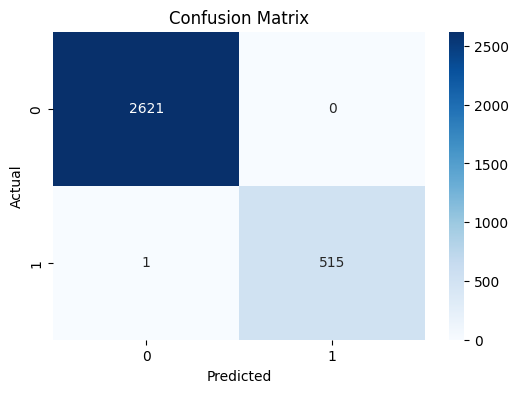

Precision: 1.00
Recall: 1.00
F1 Score: 1.00
ROC AUC Score: 1.00


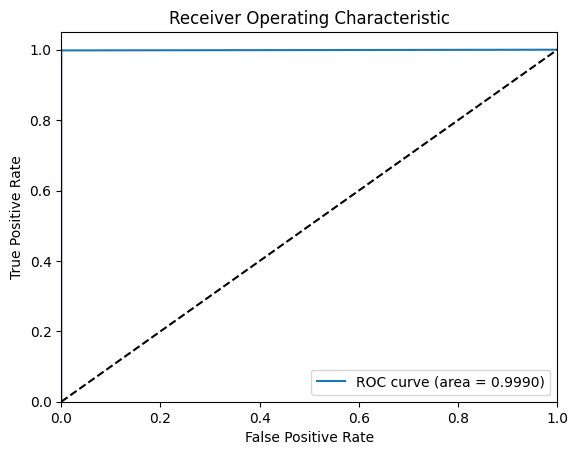

In [13]:
# Evaluation metrics
# Calculate accuracy
accuracy = accuracy_score(y_test, yhat)
print(f'Accuracy: {accuracy:.2f}')

# Calculate confusion matrix
cm = confusion_matrix(y_test, yhat)
print('Confusion Matrix:')
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision
precision = precision_score(y_test, yhat)
print(f'Precision: {precision:.2f}')

# Calculate recall
recall = recall_score(y_test, yhat)
print(f'Recall: {recall:.2f}')

# Calculate F1 score
f1 = f1_score(y_test, yhat)
print(f'F1 Score: {f1:.2f}')

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, yhat)
print(f'ROC AUC Score: {roc_auc:.2f}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, yhat)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from xgboost import plot_importance

plt.figure(figsize=(10, 8))
plot_importance(best_model, importance_type='weight')
plt.title('Feature Importance')
plt.show()